In [25]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime, time, timedelta
from feature_engineer import FeatureEngineer

In [26]:
def plot_learning_curve(evals_result):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(np.arange(len(evals_result['training']['binary_error'])),
            evals_result['training']['binary_error'], label='Training')
    ax.plot(np.arange(len(evals_result['valid_1']['binary_error'])),
            evals_result['valid_1']['binary_error'], label='Validation')
    ax.set_title('Learning Curve')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Binary Error')
    ax.legend()
    plt.show()

def plot_feature_importance(importances, feature_names):
    importance = pd.DataFrame({"Feature": feature_names,
                               "Importance": importances})
    importance.sort_values(by="Importance", ascending=False, inplace=True)
    plt.figure(figsize=(15, 30))
    sns.barplot(x="Importance", y="Feature", data=importance)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

In [27]:
def train_and_evaluate(df, n_splits=5):
    features = df.drop('target', axis=1)
    labels = df['target']

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    feature_importances = []

    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test)

        params = {
            'objective': 'binary',
            'metric': 'binary_error',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9
        }

        evals_result = {}

        model = lgb.train(
            params=params,
            train_set=train_data,
            valid_sets=[train_data, test_data],
            num_boost_round=10000,
            callbacks=[
                lgb.callback.early_stopping(10),
                lgb.callback.log_evaluation(period=100),
                lgb.callback.record_evaluation(evals_result)
            ],
        )

        y_pred = model.predict(X_test)
        y_pred = np.round(y_pred).astype(int)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        
        plot_learning_curve(evals_result)
        feature_importances.append(model.feature_importance())
    
    mean_accuracy = np.mean(accuracies)
    print(f"Mean accuracy: {mean_accuracy}")

    mean_importance = np.mean(feature_importances, axis=0)
    plot_feature_importance(mean_importance, features.columns)

    return model, evals_result

In [31]:
def create_label(df, lookbehind=15):
    df['target'] = (df['close'] > df['close'].shift(lookbehind) * 1.01 ).astype(int)
    df = df.fillna(method='ffill')
    return df

In [32]:
df = pd.read_csv('../csv/BTCUSDT_1m_20210801_20221231.csv')
fe = FeatureEngineer(df)
df = fe.feature_engineering(df)
df = create_label(df)
display(df)

# Assume 80% of the data is used for training and 20% for testing
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

/Users/tek/dev/python/learning-model/train/feature_engineer.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


,date,open,high,low,close,volume,RSI,MACD,ATR,ADX,...,OBV,High_Close_Comparison,consecutive_up,consecutive_down,double_top,double_bottom,ascending_trendline,descending_trendline,triangle_pattern,target
0,1627755600000,41306.41,41350.00,41306.41,41335.68,0.002180,68.860868,0.813032,-0.050240,0.040129,...,-0.442464,1,2,0,0,0,4.335178e+04,3.912580e+04,0,0
1,1627755720000,41344.84,41384.23,41344.84,41384.23,0.145714,73.288201,1.017305,-0.000421,0.128675,...,-0.296750,1,3,0,0,0,4.370691e+04,3.880490e+04,0,0
2,1627755780000,41384.23,41384.23,41377.79,41377.81,0.001080,71.833764,1.152493,-0.074447,0.210896,...,-0.297830,0,0,1,0,0,4.371975e+04,3.879206e+04,0,0
3,1627755840000,41377.81,41416.00,41377.81,41407.93,0.051798,74.400584,1.307888,-0.052492,0.332729,...,-0.246032,1,1,0,1,0,4.405504e+04,3.848854e+04,0,0
4,1627755900000,41407.93,41407.93,41388.26,41389.59,0.001933,70.205262,1.376719,-0.085007,0.445859,...,-0.247965,0,0,1,0,0,4.406946e+04,3.847412e+04,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740596,1672413540000,16508.20,16512.86,16498.28,16508.61,15.606035,80.867625,0.444726,-0.600789,0.748081,...,-8254.604605,0,14,0,0,0,5.003070e+06,-4.970132e+06,0,0
740597,1672413600000,16508.61,16523.98,16504.91,16504.91,18.356253,77.945828,0.495272,-0.595854,1.004441,...,-8272.960858,0,0,1,0,0,5.003077e+06,-4.970139e+06,0,0
740598,1672413660000,16504.91,16513.00,16502.58,16510.18,7.890198,79.103896,0.540242,-0.615981,1.220795,...,-8265.070660,0,1,0,0,0,5.003084e+06,-4.970145e+06,0,0
740599,1672413720000,16510.18,16517.09,16499.36,16517.09,9.953238,80.546334,0.583737,-0.613788,1.429320,...,-8255.117422,1,2,0,0,0,4.855675e+06,-4.822733e+06,0,0


[LightGBM] [Info] Number of positive: 5222, number of negative: 468762
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6668
[LightGBM] [Info] Number of data points in the train set: 473984, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011017 -> initscore=-4.497215
[LightGBM] [Info] Start training from score -4.497215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_error: 0.00408031	valid_1's binary_error: 0.00522381
Early stopping, best iteration is:
[100]	training's binary_error: 0.00408031	valid_1's binary_error: 0.00522381
Accuracy: 0.9947761949770456
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117173
           1       0.81      0.69      0.75      1

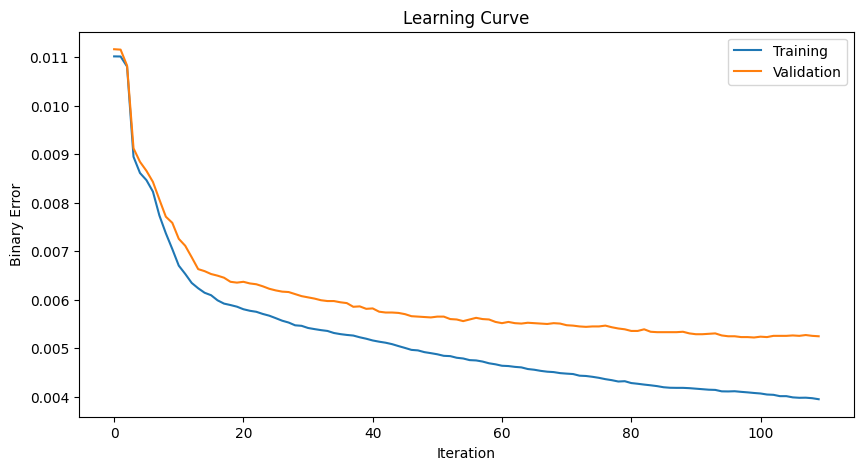

[LightGBM] [Info] Number of positive: 5184, number of negative: 468800
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6667
[LightGBM] [Info] Number of data points in the train set: 473984, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010937 -> initscore=-4.504599
[LightGBM] [Info] Start training from score -4.504599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_error: 0.00418369	valid_1's binary_error: 0.00545166
Early stopping, best iteration is:
[94]	training's binary_error: 0.00423854	valid_1's binary_error: 0.00542634
Accuracy: 0.994573656494734
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117135
           1       0.81      0.68      0.74      136

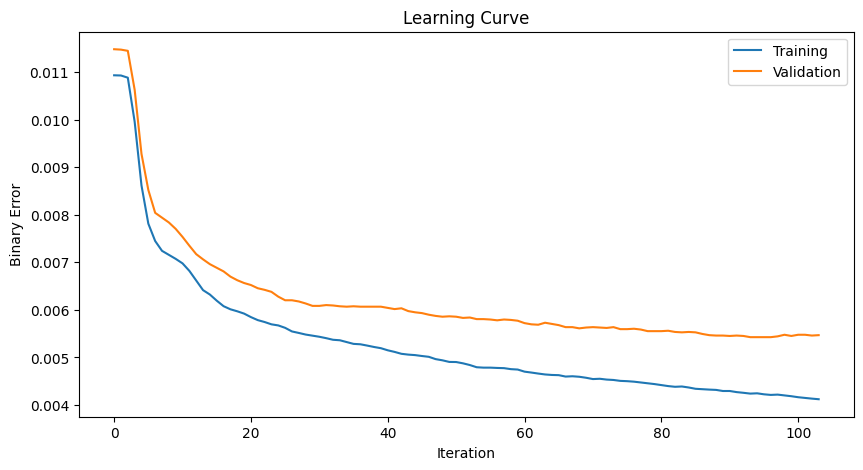

[LightGBM] [Info] Number of positive: 5293, number of negative: 468691
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6667
[LightGBM] [Info] Number of data points in the train set: 473984, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011167 -> initscore=-4.483559
[LightGBM] [Info] Start training from score -4.483559
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	training's binary_error: 0.00450226	valid_1's binary_error: 0.00529132
Accuracy: 0.9947086821496084
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117244
           1       0.78      0.69      0.74      1252

    accuracy                           0.99    118496
   macro avg       

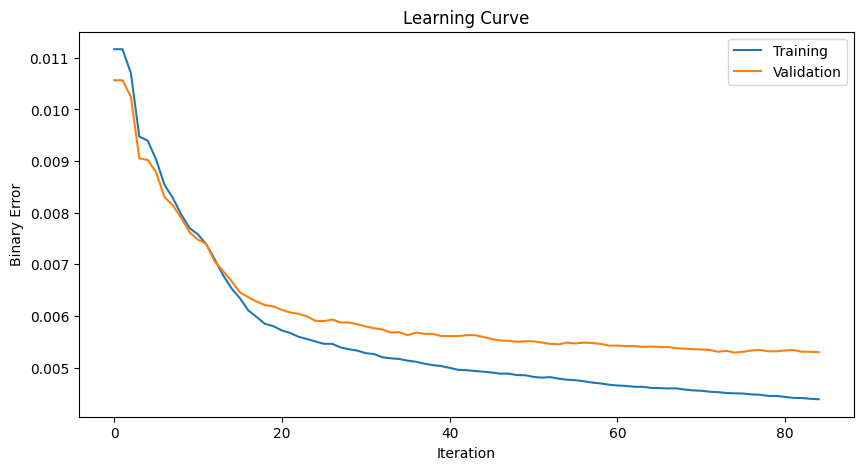

[LightGBM] [Info] Number of positive: 5218, number of negative: 468766
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6667
[LightGBM] [Info] Number of data points in the train set: 473984, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011009 -> initscore=-4.497990
[LightGBM] [Info] Start training from score -4.497990
Training until validation scores don't improve for 10 rounds
[100]	training's binary_error: 0.00424487	valid_1's binary_error: 0.00490312
Early stopping, best iteration is:
[93]	training's binary_error: 0.00430394	valid_1's binary_error: 0.00488624
Accuracy: 0.9951137591142317
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117169
           1       0.82      0.72      0.77      13

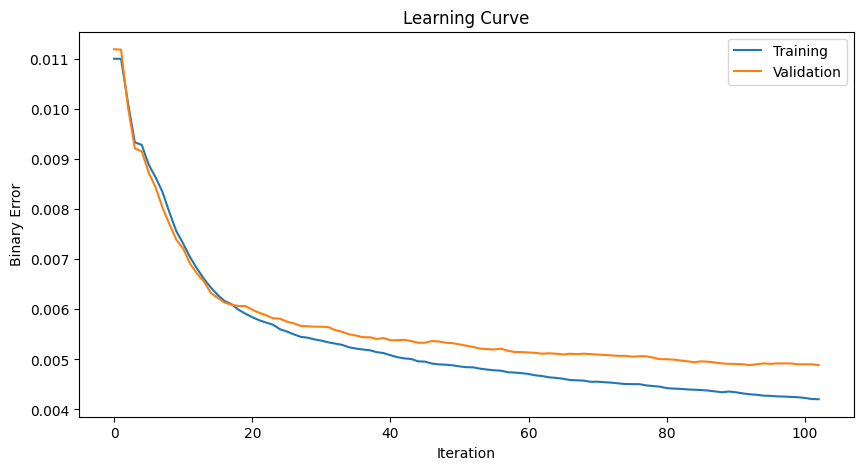

[LightGBM] [Info] Number of positive: 5263, number of negative: 468721
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6667
[LightGBM] [Info] Number of data points in the train set: 473984, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011104 -> initscore=-4.489307
[LightGBM] [Info] Start training from score -4.489307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_error: 0.00429972	valid_1's binary_error: 0.00503814
Early stopping, best iteration is:
[129]	training's binary_error: 0.00394317	valid_1's binary_error: 0.00482717
Accuracy: 0.9951728328382393
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117214
           1       0.80      0.73      0.77      1

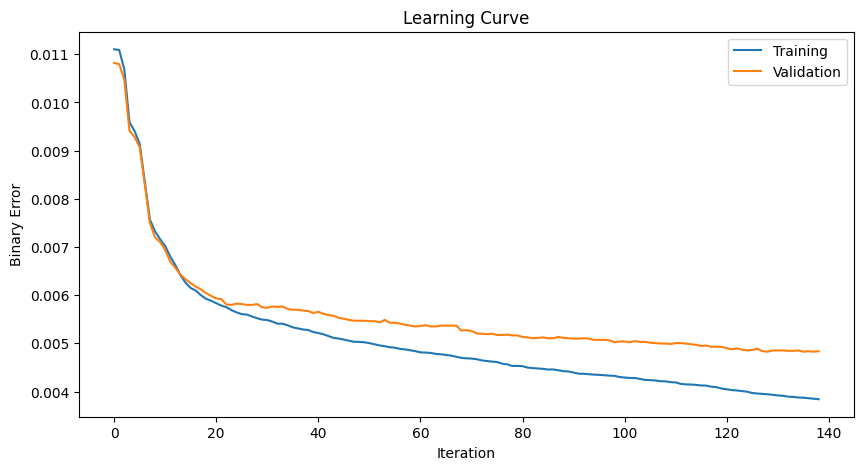

Mean accuracy: 0.9948690251147718


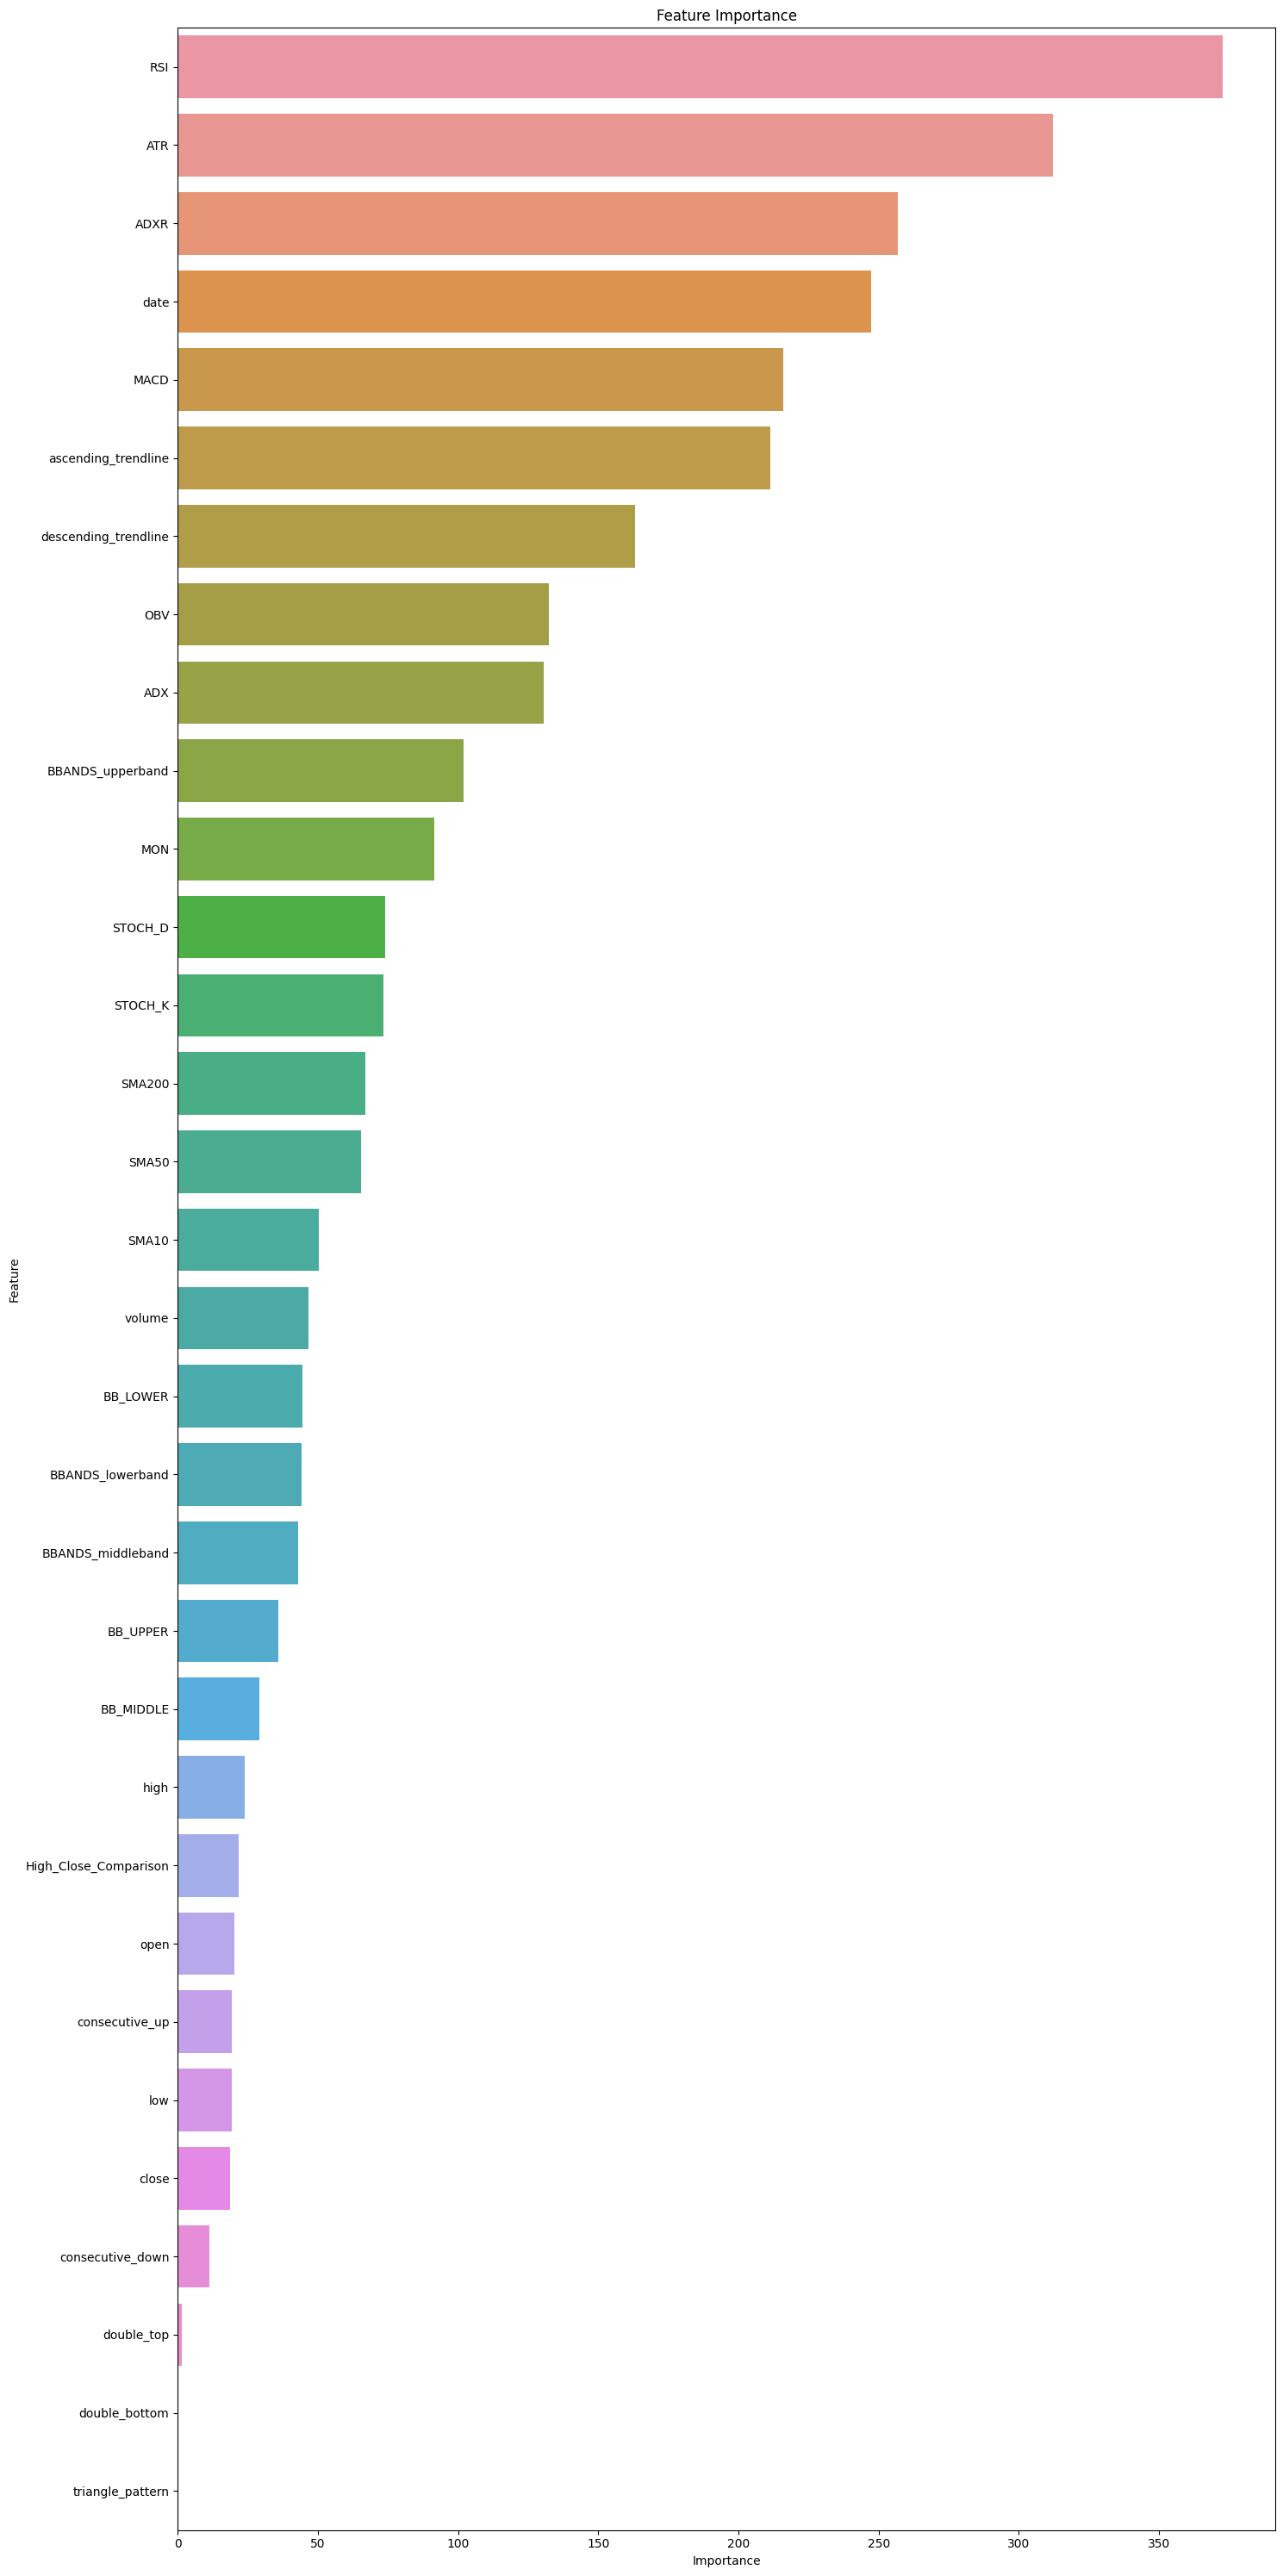

In [33]:
model, evals_result = train_and_evaluate(train_df)

# model_path = os.path.join("model", "5m_model.pkl")
# with open(model_path, "wb") as f:
#     pickle.dump(model, f)

# print(f"Model saved to {model_path}")